# PokerML

In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

Make sure that you have Vivado suite in your environment.

In [3]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

In [4]:
# from tensorflow.keras.utils import to_categorical
# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# import numpy as np

# %matplotlib inline
# seed = 0
# np.random.seed(seed)
# import tensorflow as tf

# tf.random.set_seed(seed)
# import os

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configuration

In [5]:
DATA_DIR = "data"

MODELS_DIR = 'models/'

DATA_JPG_DIR = DATA_DIR + '/augmented/jpg'
DATA_NPY_DIR = DATA_DIR + '/npy/'


IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

CREATE_DATASET = True
KERAS_TRAIN = True
QKERAS_TRAIN = True

## Create dataset

In [6]:
image_paths = []
labels = []

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

In [7]:
if CREATE_DATASET:

    for label in os.listdir(DATA_JPG_DIR):
        label_dir = os.path.join(DATA_JPG_DIR, label)
        for image_file in os.listdir(label_dir):
            image_paths.append(os.path.join(label_dir, image_file))
            labels.append(label)

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        image_paths, labels, test_size=TEST_SIZE, random_state=42, stratify=labels)


    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train_val)
    y_train_val_encoded = label_encoder.transform(y_train_val)
    y_test_encoded = label_encoder.transform(y_test)


    # Convert integer labels to categorical format
    y_train_val = to_categorical(y_train_val_encoded, NUM_CLASSES)

    # Convert integer labels to categorical format
    y_test = to_categorical(y_test_encoded, NUM_CLASSES)

    # Verify one-hot encoding
    #print("Shape of y_train_val:", y_train_val.shape)
    #print("Shape of y_test:", y_test.shape)

    X_train_val = [preprocess_image(image_path) for image_path in X_train_val]
    X_test = [preprocess_image(image_path) for image_path in X_test]

    X_train_val = np.array(X_train_val)
    X_test = np.array(X_test)
    
    classes = label_encoder.classes_


    # Save the preprocessed data
    np.save(DATA_NPY_DIR + 'X_train_val.npy', X_train_val)
    np.save(DATA_NPY_DIR + 'X_test.npy', X_test)
    np.save(DATA_NPY_DIR + 'y_train_val.npy', y_train_val)
    np.save(DATA_NPY_DIR + 'y_test.npy', y_test)
    np.save(DATA_NPY_DIR + 'classes.npy', classes)
    
else:
    X_train_val = np.load(DATA_NPY_DIR + 'X_train_val.npy')
    X_test = np.load(DATA_NPY_DIR + 'X_test.npy')
    y_train_val = np.load(DATA_NPY_DIR + 'y_train_val.npy')
    y_test = np.load(DATA_NPY_DIR + 'y_test.npy')
    classes = np.load(DATA_NPY_DIR + 'classes.npy', allow_pickle=True)

In [8]:
print('Train and validation set:', X_train_val.shape[0])
print('Test set:                ', X_test.shape[0])
print('Classes:                 ', classes.shape[0])

Train and validation set: 19968
Test set:                 4992
Classes:                  52


## Train Keras model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [10]:
if KERAS_TRAIN:
    model = Sequential()
    model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
    model.add(Conv2D(8, (3, 3), activation='relu', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(32, activation='relu', name='dense1'))
    model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))
    
    print("Model summary:")
    model.summary()

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 4)         112       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 8)         296       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense1 (Dense)              (None, 32)                50208     
                                                                 
 output (Dense)              (None, 52)  

In [11]:
if KERAS_TRAIN:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir=MODELS_DIR+'/keras',
    )
    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )

else:
    from tensorflow.keras.models import load_model

    model = load_model(MODELS_DIR + 'keras/check_best_model.h5')
    
    print("Model summary:")
    model.summary()

Epoch 1/50
1492/1498 [============================>.] - ETA: 0s - loss: 3.2533 - accuracy: 0.1117
***callbacks***
saving losses to models//keras/losses.log

Epoch 1: val_loss improved from inf to 2.49167, saving model to models//keras/check_best_model.h5

Epoch 1: val_loss improved from inf to 2.49167, saving model to models//keras/check_best_model_weights.h5

Epoch 1: saving model to models//keras/check_model_last.h5

Epoch 1: saving model to models//keras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 8s 5ms/step - loss: 3.2506 - accuracy: 0.1122 - val_loss: 2.4917 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 2/50
1497/1498 [============================>.] - ETA: 0s - loss: 2.1535 - accuracy: 0.2961
***callbacks***
saving losses to models//keras/losses.log

Epoch 2: val_loss improved from 2.49167 to 1.82259, saving model to models//keras/check_best_model.h5

Epoch 2: val_loss improved from 2.49167 to 1.82259, saving model to models//keras/


***callbacks end***

1498/1498 [==============================] - 8s 5ms/step - loss: 0.7764 - accuracy: 0.7259 - val_loss: 0.9085 - val_accuracy: 0.6943 - lr: 0.0010
Epoch 14/50
1487/1498 [============================>.] - ETA: 0s - loss: 0.7530 - accuracy: 0.7365
***callbacks***
saving losses to models//keras/losses.log

Epoch 14: val_loss did not improve from 0.88715

Epoch 14: val_loss did not improve from 0.88715

Epoch 14: saving model to models//keras/check_model_last.h5

Epoch 14: saving model to models//keras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 6s 4ms/step - loss: 0.7532 - accuracy: 0.7363 - val_loss: 0.9157 - val_accuracy: 0.6905 - lr: 0.0010
Epoch 15/50
1489/1498 [============================>.] - ETA: 0s - loss: 0.7286 - accuracy: 0.7456
***callbacks***
saving losses to models//keras/losses.log

Epoch 15: val_loss did not improve from 0.88715

Epoch 15: val_loss did not improve from 0.88715

Epoch 15: saving model 


Epoch 27: saving model to models//keras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 5s 4ms/step - loss: 0.5251 - accuracy: 0.8162 - val_loss: 0.9039 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 28/50
1495/1498 [============================>.] - ETA: 0s - loss: 0.5213 - accuracy: 0.8169
***callbacks***
saving losses to models//keras/losses.log

Epoch 28: val_loss did not improve from 0.83913

Epoch 28: val_loss did not improve from 0.83913

Epoch 28: saving model to models//keras/check_model_last.h5

Epoch 28: saving model to models//keras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 5s 4ms/step - loss: 0.5218 - accuracy: 0.8168 - val_loss: 0.9303 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 29/50
1488/1498 [============================>.] - ETA: 0s - loss: 0.5059 - accuracy: 0.8199
***callbacks***
saving losses to models//keras/losses.log

Epoch 29: val_loss did not improve from 0.83913

Epo

Epoch 42/50
1481/1498 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8918
***callbacks***
saving losses to models//keras/losses.log

Epoch 42: val_loss did not improve from 0.83913

Epoch 42: val_loss did not improve from 0.83913

Epoch 42: saving model to models//keras/check_model_last.h5

Epoch 42: saving model to models//keras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 5s 3ms/step - loss: 0.3120 - accuracy: 0.8916 - val_loss: 0.9743 - val_accuracy: 0.7544 - lr: 5.0000e-04
Epoch 43/50
1485/1498 [============================>.] - ETA: 0s - loss: 0.3012 - accuracy: 0.8962
***callbacks***
saving losses to models//keras/losses.log

Epoch 43: val_loss did not improve from 0.83913

Epoch 43: val_loss did not improve from 0.83913

Epoch 43: saving model to models//keras/check_model_last.h5

Epoch 43: saving model to models//keras/check_model_last_weights.h5

***callbacks end***

1498/1498 [=========================

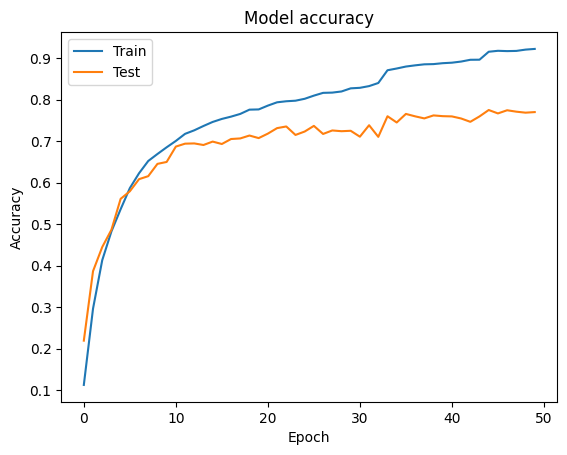

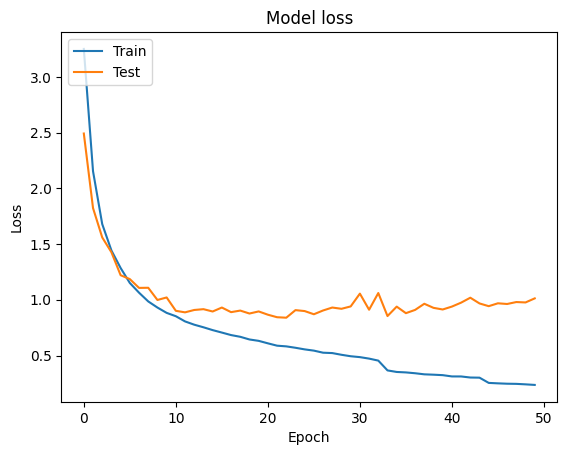

In [12]:
if KERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [13]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)

print("Keras accuracy: {:.6f}%".format(100.0 * accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

#plt.figure(figsize=(9, 9))
#_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)

156/156 [==============================] - 0s 1ms/step
Keras accuracy: 74.459135%


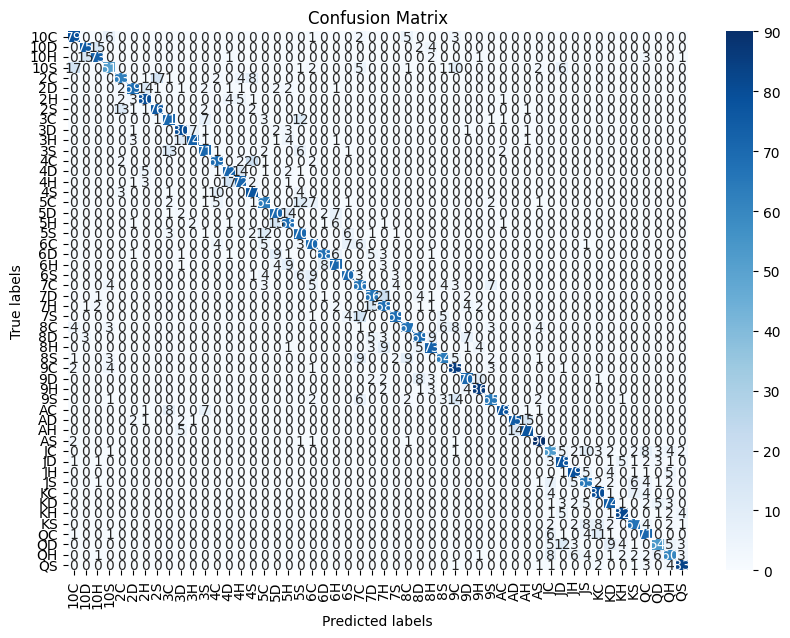

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        cm (array, shape = [n, n]): Confusion matrix
        class_names (array, shape = [n]): Array of class names
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_test_ = np.argmax(y_test, axis=1)
y_keras_ = np.argmax(y_keras, axis=1)

cm = confusion_matrix(y_test_, y_keras_)

plot_confusion_matrix(cm, classes)

## Keras to hls4ml (Post Training Quantization)

In [15]:
!mkdir -p projects

In [16]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='projects/ptq_hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Stra

/home/giuseppe/miniconda3/envs/pokerml-env/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


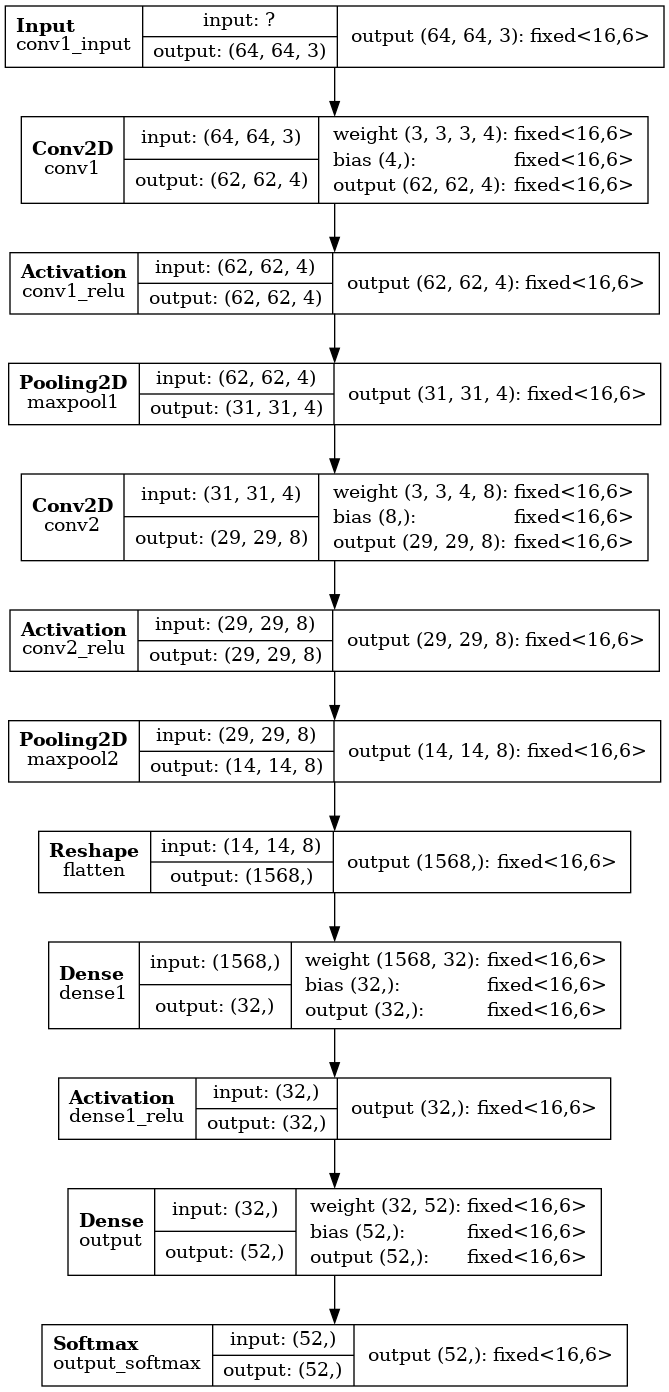

In [17]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

The following cell takes approx. 5 minutes. It tries to compile the weights in the header files, while it should load them on the run. Not big issue, but annoying.

In [18]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

print("Keras  accuracy: {}".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml accuracy: {}".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Writing HLS project
Done
Keras  accuracy: 74.45913461538461
hls4ml accuracy: 0.9815705128205128


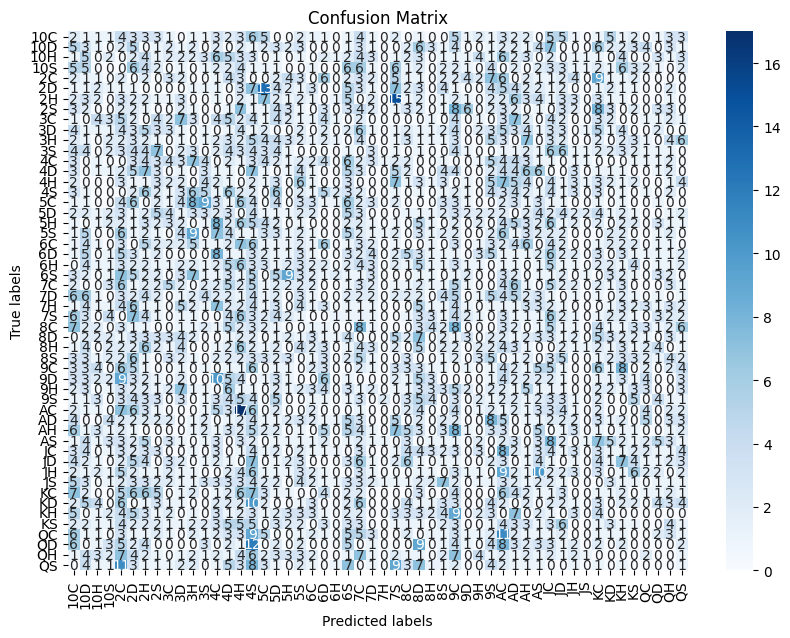

In [19]:
y_test_ = np.argmax(y_test, axis=1)
y_hls_ = np.argmax(y_hls, axis=1)

cm = confusion_matrix(y_test_, y_hls_)

plot_confusion_matrix(cm, classes)

## QKeras

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras import QDense, QActivation, QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

In [22]:
model = Sequential()
model.add(QConv2D(4,
                 (3, 3),
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 name='conv1'))
model.add(QActivation(activation=quantized_relu(6),
                      name='relu1'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool1'))
model.add(QConv2D(8,
                 (3, 3),
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 name='conv2'))
model.add(QActivation(activation=quantized_relu(6),
                      name='relu2'))
model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(QDense(32,
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 name='dense1'))
model.add(QActivation(activation=quantized_relu(6),
                      name='relu3'))
model.add(QDense(NUM_CLASSES,
                 kernel_quantizer=quantized_bits(6),
                 bias_quantizer=quantized_bits(6), 
                 activation='softmax',
                 name='output'))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
if QKERAS_TRAIN:
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir=MODELS_DIR + 'qkeras',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    

else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    
    model = load_model(MODELS_DIR + 'qkeras/KERAS_check_best_model.h5')

Epoch 1/50
   1/1498 [..............................] - ETA: 39:22 - loss: 4.1462 - accuracy: 0.0000e+00WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0042s vs `on_train_batch_end` time: 0.0051s). Check your callbacks.


1497/1498 [============================>.] - ETA: 0s - loss: 3.7600 - accuracy: 0.0487
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 1: val_loss improved from inf to 3.51568, saving model to models/qkeras/check_best_model.h5

Epoch 1: val_loss improved from inf to 3.51568, saving model to models/qkeras/check_best_model_weights.h5

Epoch 1: saving model to models/qkeras/check_model_last.h5

Epoch 1: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 16s 10ms/step - loss: 3.7600 - accuracy: 0.0487 - val_loss: 3.5157 - val_accuracy: 0.0885 - lr: 0.0010
Epoch 2/50
1491/1498 [============================>.] - ETA: 0s - loss: 3.3902 - accuracy: 0.1242
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 2: val_loss improved from 3.51568 to 3.23856, saving model to models/qkeras/check_best_model.h5

Epoch 2: val_loss improved from 3.51568 to 3.23856, saving model to models/qkeras/check_bes


Epoch 13: val_loss improved from 1.58168 to 1.47746, saving model to models/qkeras/check_best_model_weights.h5

Epoch 13: saving model to models/qkeras/check_model_last.h5

Epoch 13: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 12s 8ms/step - loss: 1.3515 - accuracy: 0.6682 - val_loss: 1.4775 - val_accuracy: 0.6014 - lr: 0.0010
Epoch 14/50
1495/1498 [============================>.] - ETA: 0s - loss: 1.2801 - accuracy: 0.6920
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 14: val_loss improved from 1.47746 to 1.41025, saving model to models/qkeras/check_best_model.h5

Epoch 14: val_loss improved from 1.47746 to 1.41025, saving model to models/qkeras/check_best_model_weights.h5

Epoch 14: saving model to models/qkeras/check_model_last.h5

Epoch 14: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 13s 9ms/step - loss

Epoch 26/50
1496/1498 [============================>.] - ETA: 0s - loss: 0.8397 - accuracy: 0.8268
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 26: val_loss did not improve from 1.16626

Epoch 26: val_loss did not improve from 1.16626

Epoch 26: saving model to models/qkeras/check_model_last.h5

Epoch 26: saving model to models/qkeras/check_model_last_weights.h5

***callbacks end***

1498/1498 [==============================] - 13s 9ms/step - loss: 0.8396 - accuracy: 0.8268 - val_loss: 1.1936 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 27/50
1494/1498 [============================>.] - ETA: 0s - loss: 0.8221 - accuracy: 0.8329
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 27: val_loss improved from 1.16626 to 1.16286, saving model to models/qkeras/check_best_model.h5

Epoch 27: val_loss improved from 1.16626 to 1.16286, saving model to models/qkeras/check_best_model_weights.h5

Epoch 27: saving model to models/qkeras/check_model_last.h5

Epoch 27: s


***callbacks end***

1498/1498 [==============================] - 13s 9ms/step - loss: 0.6924 - accuracy: 0.8751 - val_loss: 1.1489 - val_accuracy: 0.6863 - lr: 0.0010
Epoch 40/50
1496/1498 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.8779
***callbacks***
saving losses to models/qkeras/losses.log

Epoch 40: val_loss improved from 1.14744 to 1.13829, saving model to models/qkeras/check_best_model.h5

Epoch 40: val_loss improved from 1.14744 to 1.13829, saving model to models/qkeras/check_best_model_weights.h5

Epoch 40: saving model to models/qkeras/check_model_last.h5

Epoch 40: saving model to models/qkeras/check_model_last_weights.h5

Epoch 40: saving model to models/qkeras/check_model_epoch40.h5

***callbacks end***

1498/1498 [==============================] - 13s 9ms/step - loss: 0.6871 - accuracy: 0.8778 - val_loss: 1.1383 - val_accuracy: 0.6841 - lr: 0.0010
Epoch 41/50
1494/1498 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.8

In [ ]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))

print("QKeras accuracy: {:.6f}%".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

## QKeras to hls4ml (Quantization Aware Training)

The following cell takes approx. 5 minutes. It tries to compile the weights in the header files, while it should load them on the run. Not big issue, but annoying.

In [ ]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()

In [ ]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
#np.save('model_2/y_qkeras.npy', y_qkeras)
#np.save('model_2/y_hls.npy', y_hls)

In [ ]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#model_ref = load_model('model_1/KERAS_check_best_model.h5')
#y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy quantized: {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml:    {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

In [ ]:
# fig, ax = plt.subplots(figsize=(9, 9))
# _ = plotting.makeRoc(y_test, y_ref, classes)
# plt.gca().set_prop_cycle(None)  # reset the colors
# _ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
# plt.gca().set_prop_cycle(None)  # reset the colors
# _ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

# from matplotlib.lines import Line2D

# lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
# from matplotlib.legend import Legend

# leg = Legend(ax, lines, labels=['baseline', 'quantized', 'hls4ml'], loc='lower right', frameon=False)
# ax.add_artist(leg)

In [ ]:
y_test_ = np.argmax(y_test, axis=1)
y_qkeras_ = np.argmax(y_qkeras, axis=1)

cm = confusion_matrix(y_test_, y_qkeras_)

plot_confusion_matrix(cm, classes)